In [1]:
%run _common.ipynb
import jax
from jax import Array
import jax.numpy as jnp
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt

from neuralconstitutive.constitutive import FromLogDiscreteSpectrum
from neuralconstitutive.relaxation_spectrum import HonerkampWeeseBimodal
from neuralconstitutive.pyRespect import estimate_continous_spectrum
from neuralconstitutive.jax.tipgeometry import Spherical, AbstractTipGeometry
from neuralconstitutive.trajectory import Trajectory, make_triangular
from neuralconstitutive.jax.ting import force_approach, force_retract
from neuralconstitutive.nn import FullyConnectedNetwork
from neuralconstitutive.models import BernsteinNN
from neuralconstitutive.training import loss_total, train_model

2023-12-01 12:57:29.588070: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 1. Mock data generation

We use the bimodal log-Gaussian model first introduced in J. Honerkamp and J. Weese, Macromolecules (1989).

We plot the spectrum below:

Text(0, 0.5, 'Relaxation Spectrum H(τ)[Pa]')

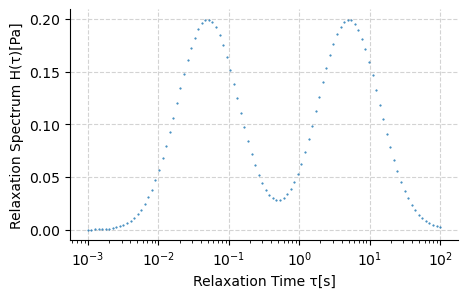

In [2]:
bimodal = FromLogDiscreteSpectrum(HonerkampWeeseBimodal())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(*bimodal.discrete_spectrum, ".")
ax.set_xscale("log", base=10)
ax.set_xlabel("Relaxation Time τ[s]")
ax.set_ylabel("Relaxation Spectrum H(τ)[Pa]")

Given a sufficiently densely sampled relaxation spectrum $\{\tau_i, h_i\}_{i=0}^N$, where $h_i = H(\tau=\tau_i)$,

the relaxation function can be approximated by the following equation:
\begin{equation}
G(t) = \sum_{i=0}^N g_i e^{-t/\tau_i}; \quad g_i = h_i\cdot h_0
\end{equation}
where $h_0 = \frac{\log(\tau_N)-\log(\tau_0)}{N}$

Text(0, 0.5, 'Relaxation Function[Pa]')

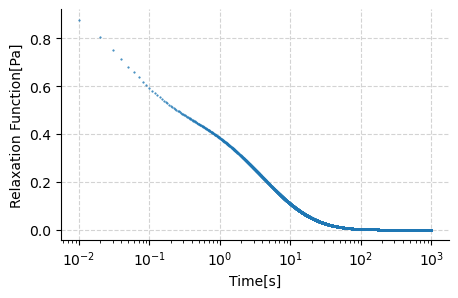

In [3]:
t_data = np.linspace(0, 1e3, 100000)[1:]  # to avoid t=0
g_data = bimodal.relaxation_function(t_data)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t_data, g_data, ".")
ax.set_xscale("log", base=10)
ax.set_xlabel("Time[s]")
ax.set_ylabel("Relaxation Function[Pa]")

## 2. Run pyRespect on the mock data

Here, we run our refactored version of pyRespect on the mock data.

The original pyRespect code first interpolates the data points onto 100 log-equi-spaced grid points before the main algorithm.

Here, the code has been tweaked so that either the interpolation can be turned off, or the number of grid points be changed.

However, note that too many time points can result in a memory overflow error (or greatly slow down the algorithm). 

Interpolating t, G to 100 points
Interpolating t, G to 200 points
Interpolating t, G to 500 points


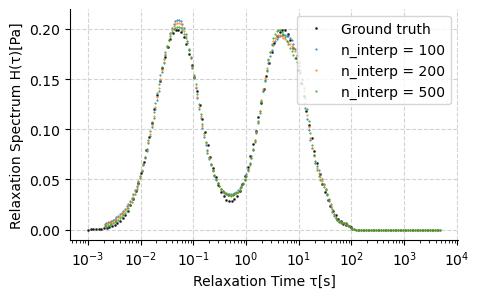

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(
    *bimodal.discrete_spectrum,
    ".",
    color="black",
    markersize=2.0,
    alpha=0.7,
    label="Ground truth",
)
for n_interp in (100, 200, 500):
    t_estimated, h_estimated, _ = estimate_continous_spectrum(
        t_data, g_data, n_interpolation=n_interp, n_spectrum_points=200
    )
    ax.plot(
        t_estimated,
        h_estimated,
        ".",
        alpha=1.0,
        label=f"n_interp = {n_interp}",
    )
ax.set_xscale("log", base=10)
ax.set_xlabel("Relaxation Time τ[s]")
ax.set_ylabel("Relaxation Spectrum H(τ)[Pa]")
ax.legend()

## 3. Calculate force curve corresponding to the mock data

In [5]:
tip = Spherical(1.0)
Dt = 1e-2
app, ret = make_triangular(1.0, 1e-2, 10.0)

f_app = force_approach(app, bimodal.relaxation_function, tip)
f_ret = force_retract(app, ret, bimodal.relaxation_function, tip)

Text(0.5, 0, 'Time')

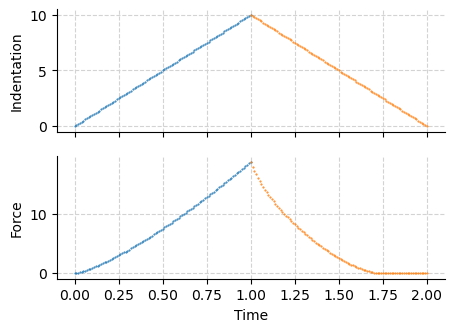

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(5, 3.5), sharex=True)
axes[0].plot(app.t, app.z(app.t), ".")
axes[0].plot(ret.t, ret.z(ret.t), ".")
axes[0].set_ylabel("Indentation")

axes[1].plot(app.t, f_app, ".")
axes[1].plot(ret.t, f_ret, ".")
axes[1].set_ylabel("Force")
axes[1].set_xlabel("Time")

## 4. Train neural network on the simulated force data

Text(0.5, 1.0, 'NN prediction before training')

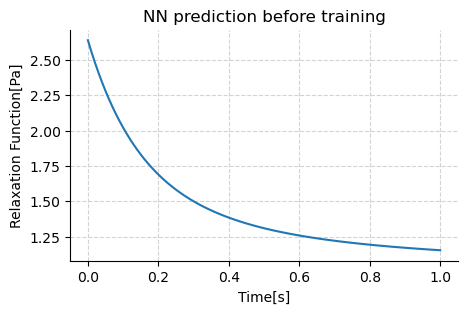

In [7]:
fcn = FullyConnectedNetwork(
    ["scalar", 20, 20, 20, 20, "scalar"],
    activation=jnp.sin,
    final_activation=jax.nn.softplus,
)
phi_bern = BernsteinNN(fcn, 100)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(app.t, phi_bern(app.t))
ax.set_xlabel("Time[s]")
ax.set_ylabel("Relaxation Function[Pa]")
ax.set_title("NN prediction before training")

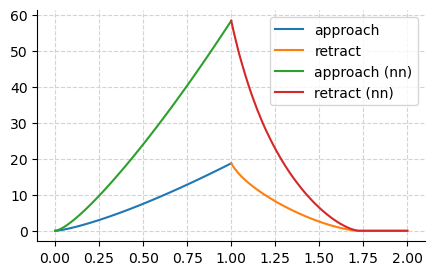

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
f_app_pred = force_approach(app, phi_bern, tip)
f_ret_pred = force_retract(app, ret, phi_bern, tip)
ax.plot(app.t, f_app, label="approach")
ax.plot(ret.t, f_ret, label="retract")
ax.plot(app.t, f_app_pred, label="approach (nn)")
ax.plot(ret.t, f_ret_pred, label="retract (nn)")
ax.legend()

In [9]:
trained_model, loss_history = train_model(
    phi_bern,
    (app, ret),
    (f_app, f_ret),
    tip,
    loss_total,
    optimizer=optax.rmsprop(5e-3),
    max_epochs=2000,
)

step=0, loss=646.4535109369459
step=1, loss=475.8191529542835
step=2, loss=384.1252478266339
step=3, loss=337.90049534038474
step=4, loss=318.5486187084349
step=5, loss=307.39552826423875
step=6, loss=298.05280877138034
step=7, loss=289.410503374436
step=8, loss=281.06717532769255
step=9, loss=273.1014862983683
step=10, loss=265.39207969293193
step=11, loss=257.92477870869067
step=12, loss=250.73043082760728
step=13, loss=243.70450863972013
step=14, loss=236.88009935656208
step=15, loss=230.20266016416446
step=16, loss=223.6731321961224
step=17, loss=217.36426948505994
step=18, loss=211.1756288546312
step=19, loss=205.16348711237015
step=20, loss=199.23905739815478
step=21, loss=193.47487729624862
step=22, loss=187.84487792471566
step=23, loss=182.39270291819992
step=24, loss=176.98186817575544
step=25, loss=171.7532868617108
step=26, loss=166.6256866824716
step=27, loss=161.585179741226
step=28, loss=156.69568067604888
step=29, loss=151.93688213941164
step=30, loss=147.27039751174175


## 5. Inspect training results

Text(0.5, 0, 'Time $t$ (a.u.)')

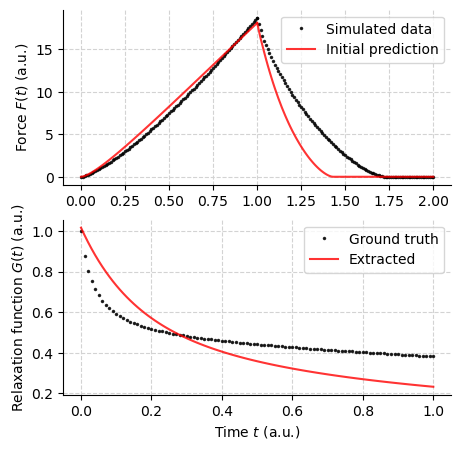

In [15]:
# %%
F_app = force_approach(app, trained_model, tip)
F_ret = force_retract(app, ret, trained_model, tip)

plot_kwargs = {"markersize": 3.0, "alpha": 0.8}
fig, axes = plt.subplots(2, 1, figsize=(5, 5))

axes[0].plot(app.t, f_app, ".", color="k", label="Simulated data", **plot_kwargs)
axes[0].plot(ret.t, f_ret, ".", color="k", **plot_kwargs)
# axes[0].plot(t_app, F_app, "-", color="royalblue", label="Prediction", **plot_kwargs)
# axes[0].plot(t_ret, F_ret, "-", color="royalblue", **plot_kwargs)
axes[0].plot(app.t, F_app, "-", color="red", label="Initial prediction", **plot_kwargs)
axes[0].plot(ret.t, F_ret, "-", color="red", **plot_kwargs)
axes[0].set_ylabel("Force $F(t)$ (a.u.)")

axes[1].plot(
    app.t,
    bimodal.relaxation_function(app.t),
    ".",
    color="k",
    label="Ground truth",
    **plot_kwargs,
)
axes[1].set_ylabel("Relaxation function $G(t)$ (a.u.)")
axes[1].plot(
    app.t,
    trained_model(app.t),
    "-",
    color="red",
    label="Extracted",
    **plot_kwargs,
)


for ax in axes:
    ax.grid(color="lightgray", linestyle="--")
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.legend()
axes[-1].set_xlabel("Time $t$ (a.u.)")

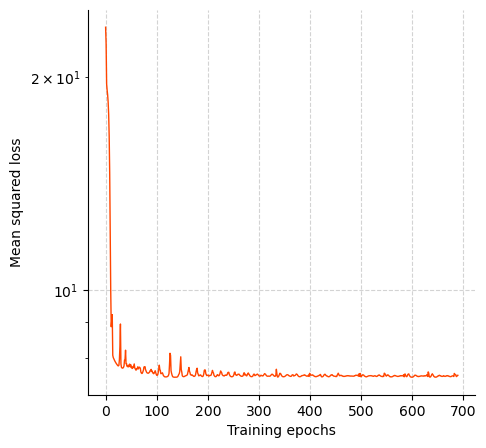

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(loss_history[:690], color="orangered", linewidth=1.0)
ax.set_xlabel("Training epochs")
ax.set_ylabel("Mean squared loss")
ax.set_yscale("log")
ax.grid(color="lightgray", linestyle="--")
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)